# Test scripts on command line
Use this notebook as a test space

In [5]:
!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
!pip install pystac_client
from platform import python_version
python_version()
import sys
import os
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils
from pyproj import CRS, Transformer
import geopandas as gpd
import maplib_folium

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/projects/Developer/icesat2_boreal/dps/requirements_main.txt'
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
%%time
!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t ATL08_filt -y 2022 -m_list 04 --maap_version tile_atl08
#!python /projects/icesat2_boreal/lib/build_tindex_master.py -t ATL08_filt -y 2022 -m run_LC_height_thresholds -o /projects/my-private-bucket/

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		tile_atl08
Type:		ATL08_filt
Year:		2022
Month:		['04']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists
                                             s3_path  ...                                               file
0  s3://maap-ops-workspace/lduncanson/dps_output/...  ...  atl08_005_30m_filt_topo_landsat_20220418_4483.csv
2  s3://maap-ops-workspace/lduncanson/dps_output/...  ...  atl08_005_30m_filt_topo_landsat_20220418_4476.csv
4  s3://maap-ops-workspace/lduncanson/dps_output/...  ...  atl08_005_30m_filt_topo_landsat_20220418_45970...
6  s3://maap-ops-workspace/lduncanson/dps_output/...  ...  atl08_005_30m_filt_topo_landsat_20220418_4

### Read in some tiles layers

<AxesSubplot:>

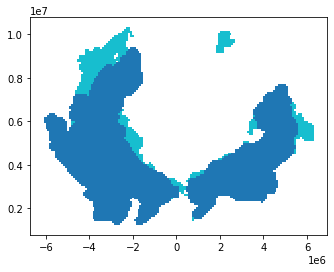

In [6]:

dem_tiles_index_path = '/projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson'
dem_tiles_index = gpd.read_file(dem_tiles_index_path)
dem_tiles_index['tile_num'] = dem_tiles_index.index

boreal_tile_index_path = '/projects/my-public-bucket/boreal_tiles_v003.gpkg'
boreal_tile_index = gpd.read_file(boreal_tile_index_path)
boreal_tile_index.plot(column='tile_version')

#boreal_tile_index[boreal_tile_index.tile_version=='version 2']

In [7]:
c = gpd.read_file('/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map.gpkg')
c.path.to_list()[0]

DriverError: /projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map.gpkg: No such file or directory

In [ ]:
if False:
    # One time, make a column with the s3 path
    c['s3_path'] = c['path'].str.replace('https://esa-worldcover.s3.eu-central-1.amazonaws.com', 's3://esa-worldcover') + '/' + c['file']

    c.s3_path.to_list()[0]
    c.to_file('/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg', driver='GPKG', overwrite=True)

#### Set up vars to pass to each script

In [9]:
#TILE_NUM = 12967
#INDEX_FN = '/projects/shared-buckets/lduncanson/dem30m_tiles_v2.geojson'#
#INDEX_LYR = 'dem30m_tiles_v2'

ID_COL_NAME = 'tile_num'
TILE_NUM = 3653 #1933 #3585 #1927 #131 #3417# 4253
INDEX_FN = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
INDEX_LYR = 'boreal_tiles_v003'



if False:
    HYBAS_FILE = 'hybas_lake_as_lev07_v1c'
    ID_COL_NAME = 'HYBAS_ID'
    TILE_NUM = 4070084980 #4070000010 #3417# 4253
    INDEX_FN = f'/projects/my-public-bucket/analyze_agb/hydrobasins/{HYBAS_FILE}.shp'
    ADD_STR = '-reprj'
    INDEX_REPRJ_FN = INDEX_FN.replace('.shp', ADD_STR+'.gpkg')
    
    # Reproject hydrobasin to equal area (boreal_tiles)
    gpd.read_file(INDEX_FN).to_crs(boreal_tile_index.crs).to_file(INDEX_REPRJ_FN, driver='GPKG')
    
    INDEX_LYR = HYBAS_FILE + ADD_STR
    z = gpd.read_file(INDEX_FN)
    
if False:
    z[z[ID_COL_NAME]==TILE_NUM].plot()

    z = gpd.read_file(INDEX_REPRJ_FN)
    z[z[ID_COL_NAME]==TILE_NUM].plot()

In [ ]:
c = gpd.read_file('/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg')
c.head()

## Run build_stack.py with hydrobasins
* reprojected to equal area using boreal_tiles_index
* s0 output has same res and crs as output AGB vrt

In [245]:
RASTER_NAME = 'esa_worldcover_v100_2020'
COVAR_TILE_FN = '/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg'
IN_COVAR_S3_COL = 's3_path'
NODATA_VAL = 0

# This needs to be correctlyy in 4326 - 
RASTER_NAME = 'biomass_prelim'
COVAR_TILE_FN = '/projects/shared-buckets/lduncanson/DPS_tile_lists/AGB_tindex_master.json'
IN_COVAR_S3_COL = 's3'
NODATA_VAL = -9999

Reset projection and reproject...
/projects/my-public-bucket/analyze_agb/AGB_tindex_master.json


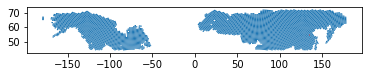

In [246]:
x = gpd.read_file(COVAR_TILE_FN)

if RASTER_NAME == 'biomass_prelim':

    print('Reset projection and reproject...')
    x = x.set_crs(boreal_tile_index.crs, allow_override=True, inplace=True).to_crs(4326)

    # Write a new JSON that should have the prj set correctly in 4326
    COVAR_TILE_FN = os.path.join('/projects/my-public-bucket/analyze_agb' , os.path.split(COVAR_TILE_FN)[1])
    print(COVAR_TILE_FN)
    x.to_file(COVAR_TILE_FN, driver='GeoJSON', overwrite=True)

# Verify 4326
ax = x.plot()
z[z[ID_COL_NAME]==TILE_NUM].to_crs(4326).plot(color='red', ax=ax)


In [247]:
# index shapes should be in equal area
# covar tiles should be in 4326
args = f"--in_tile_fn {INDEX_REPRJ_FN} \
--in_tile_id_col {ID_COL_NAME} \
--in_tile_num {TILE_NUM} \
--tile_buffer_m 0 \
--in_tile_layer {INDEX_LYR} \
-o /projects/test_data/ \
--topo_off \
--covar_src_name {RASTER_NAME} \
--covar_tile_fn {COVAR_TILE_FN} \
--in_covar_s3_col {IN_COVAR_S3_COL} \
--input_nodata_value {NODATA_VAL} \
--clip" #<-- testing a clip to polygon
print(args)
!python build_stack.py $args

--in_tile_fn /projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_as_lev07_v1c-reprj.gpkg --in_tile_id_col HYBAS_ID --in_tile_num 4070084980 --tile_buffer_m 0 --in_tile_layer hybas_lake_as_lev07_v1c-reprj -o /projects/test_data/ --topo_off --covar_src_name biomass_prelim --covar_tile_fn /projects/my-public-bucket/analyze_agb/AGB_tindex_master.json --in_covar_s3_col s3 --input_nodata_value -9999 --clip
/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
The covariate's filename(s) intersecting the 0 m bbox for tile id 4070084980:
 s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_ubuntu/master/2021/10/16/05/28/01/047798/boreal_agb_20211016_3975_cog.tif
s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_ubuntu

In [248]:
cog_fn = '/projects/tmp/esa_worldcover_v100_2020_131_cog.tif'
cog_fn = f'/projects/tmp/{RASTER_NAME}_{TILE_NUM}_cog.tif'
covar_stack_names = ['esa worldcover']

/projects/tmp/biomass_prelim_4070084980_cog.tif
4
(3813, 1930)
(3813, 1930)
-1.0075219858189395e+43


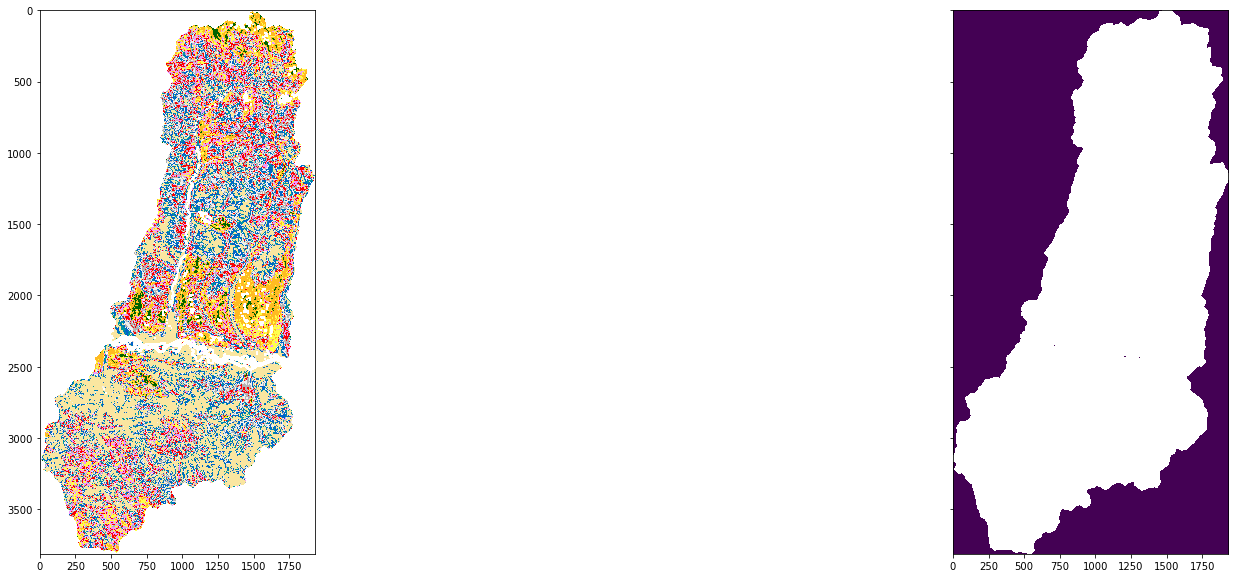

In [249]:
## %%time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio
from rasterio.plot import show_hist, show
import numpy.ma as ma

# Read back in the topo_stack_cog_fn and plot
print(cog_fn)
with rasterio.open(cog_fn) as dataset:

    print(dataset.count)
    
    covar_stack = dataset.read(1)
    print(covar_stack.shape)

    lc_mask = covar_stack.copy()
    print(lc_mask.shape)
    
    # For LC value of interest, set to 1, else mask out
    LC_VAL = 90
    #lc_mask = np.ma.masked_array(covar_stack, mask=covar_stack[covar_stack != 10], fill_value=1)
    #lc_mask = ma.masked_where(covar_stack == LC_VAL, 1)
    lc_mask[np.where(covar_stack > 0)] = 0
    lc_mask[np.where(covar_stack == LC_VAL)] = 1
    
    lc_mask = ma.masked_values(lc_mask, 0)
    print(lc_mask.sum())
    
    names_worldcover = ['nodata','Trees', 'Shrubland', 'Grassland','Cropland','Built-up','Barren / sparse vegetation','Snow and ice','Open water','Herbaceous wetland','Mangroves','Moss and lichen']
    cols_worldcover = ["white","#006400","#ffbb22","#ffff4c","#f096ff","#fa0000","#b4b4b4","#f0f0f0","#0064c8","#0096a0","#00cf75","#fae6a0"]
    #cols_worldcover = ["white","green","orange","yellow","purple","red","brown","gray","blue","pink","cyan","black"]
    cols_mask = ["white", "red"]
    # Plot data using nicer colors

    values_worldcover = [0,10,20,30,40,50,60,70,80,90,95,100]
    values_mask = [0,1]
    
    cmap_worldcover = ListedColormap(cols_worldcover)
    norm_worldcover = BoundaryNorm(values_worldcover, len(cols_worldcover))
    
    cmap_masked = ListedColormap(cols_mask)
    norm_masked= BoundaryNorm(values_mask, len(cols_mask))

    # To plot with a legend:
    # https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30,10), sharex=True, sharey=True)
    ax1.imshow(covar_stack, cmap=cmap_worldcover, norm=norm_worldcover)
    ax2.imshow(lc_mask, clim=(0,1))
    #show(lc_mask, cmap=cmap_masked, norm=norm_masked)
    #show_hist(lc_mask, bins=len(values_masked)+1, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram of ESA Worldcover Class Values")

(114, 58)
0 100


TypeError: Invalid shape (58,) for image data

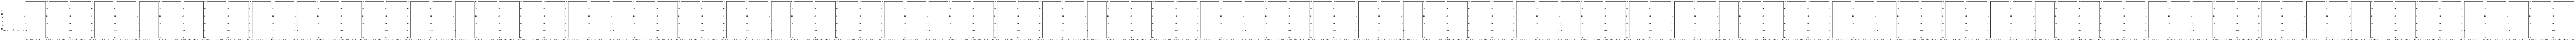

In [195]:
# This should work once you figure out the move axis of the stack: need 3 bands
n: int = len(covar_stack)
covar_stack_cmaps = ["Spectral"]
print(covar_stack.shape)

fig, axes = plt.subplots(1,n, figsize=(n*3,5))

for i in range(n):
    
    print(covar_stack[i].min(), covar_stack[i].max())
    array_to_show = covar_stack[i]
    clims = (np.nanpercentile(covar_stack[i], 10), np.nanpercentile(covar_stack[i], 90))
    
    if 'elevation' in covar_stack_names[i]:
        #Replace elevation with its hillshade for display purposes
        array_to_show = hillshade(covar_stack[i],315,45)
        clims = None
    
    show(array_to_show, ax=axes[i], cmap=covar_stack_cmaps[i], clim=clims, title=covar_stack_names[i])
    
    fig, (axmap, axhist) = plt.subplots(1,2, figsize=(10,5))
    show(array_to_show, ax=axmap, cmap=covar_cmaps[i], clim=clims, title=covar_stack_names[i])
    show_hist(covar_stack[i], ax=axhist, title=covar_stack_names[i], bins=50, lw=0.0, stacked=True, alpha=1)


if False:
    fig, axes = plt.subplots(1,n, figsize=(n*3,30))

    for i in range(n):
        show_hist(covar_stack[i], ax=axes[i], title=covar_stack_names[i], bins=50, lw=0.0, stacked=True, alpha=1)

#### Test a run of the topo stacks: 3.1.5_dps.py

In [7]:
args = f"--in_tile_fn {INDEX_FN} \
--in_tile_num {TILE_NUM} \
--tile_buffer_m 120 \
--in_tile_layer {INDEX_LYR} \
-o /projects/test_data/ \
--topo_tile_fn /projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson"
print(args)
!python 3.1.5_dps.py $args

--in_tile_fn /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg --in_tile_num 3585 --tile_buffer_m 120 --in_tile_layer boreal_tiles_v003 -o /projects/test_data/ --topo_tile_fn /projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson
/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
The DEM filename(s) intersecting the 120 m bbox for tile id 3585:
 s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N45_00_W114_00_DEM/Copernicus_DSM_COG_10_N45_00_W114_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N45_00_W115_00_DEM/Copernicus_DSM_COG_10_N45_00_W115_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N46_00_W114_00_DEM/Copernicus_DSM_COG_10_N46_00_W114_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N46_00_W115_0

#### Test a run of the MS comp stacks: 3.1.2_dps.py

In [6]:
MS_DATA_TYPE = 'HLS'#'LS8' # 'HLS'
if MS_DATA_TYPE == 'LS8':
    SAT_API = 'https://landsatlook.usgs.gov/sat-api'
else:
    SAT_API = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'
MAX_CLOUDS = 5
SEASON_START = '08-15'
SEASON_STOP = '09-01'
YEAR_START = '2019'
YEAR_STOP = '2021'
RUN_NAME = f'mc{MAX_CLOUDS}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}'
RUN_NAME

'mc5_08-15_09-01_2019_2021'

In [8]:
args = f"-i {INDEX_FN} \
--in_tile_num {TILE_NUM+1} \
-lyr {INDEX_LYR} \
-o /projects/test_data/HLS_test_redo \
-a {SAT_API} \
--tile_buffer_m 0 \
-sy {YEAR_START} -ey {YEAR_STOP} -smd {SEASON_START} -emd {SEASON_STOP} -mc {MAX_CLOUDS} -t {MS_DATA_TYPE}"
print(args)
!python 3.1.2_dps.py $args

-i /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg --in_tile_num 3586 -lyr boreal_tiles_v003 -o /projects/test_data -a https://cmr.earthdata.nasa.gov/stac/LPCLOUD --tile_buffer_m 0 -sy 2019 -ey 2021 -smd 08-15 -emd 09-01 -mc 5 -t HLS
/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Tiles path:		 /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg
Tile number:		 3586
Output res (m):		 30
in_bbox:		 [4418522.058381095, 2943303.9971664073, 4508522.093307847, 3033304.052732898]
bbox 4326:		 [-114.22290821429826, 44.729319123381565, -112.65431254208572, 45.86468326445354]
get HLS data
run function
opening client
start_month_day:		 08-15
start date, end date:		 2019-08-15T00:00:00Z 2019-09-01T23:59:59Z

Conducting HLS searc

#### Test a run of tile_atl08.py

In [10]:
%%time
args = f"\
-LC_filter True \
--extract_covars \
--do_30m \
--do_dps \
-years_list 2019 2020 2021 \
-o /projects/my-public-bucket/atl08_filt_covar_tiles \
-in_tile_num {TILE_NUM} \
-in_tile_fn {INDEX_FN} \
-in_tile_layer {INDEX_LYR} \
-in_tile_id_col tile_num \
-csv_list_fn /projects/shared-buckets/lduncanson/DPS_tile_lists/fall2022/ATL08_tindex_master.csv \
-topo_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv \
-landsat_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master.csv \
-landsat_cols_list Blue Green Red NIR SWIR SWIR2 NDVI SAVI MSAVI NDMI EVI NBR NBR2 TCB TCG TCW ValidMask Xgeo Ygeo JulianDate yearDate \
-user_stacks nathanmthomas \
-user_atl08 lduncanson \
-thresh_sol_el 5 \
-v_ATL08 5 -minmonth 4 -maxmonth 10"
print(args)
!python tile_atl08.py $args

-LC_filter True --extract_covars --do_30m --do_dps -years_list 2019 2020 2021 -o /projects/my-public-bucket/atl08_filt_covar_tiles -in_tile_num 3653 -in_tile_fn /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg -in_tile_layer boreal_tiles_v003 -in_tile_id_col tile_num -csv_list_fn /projects/shared-buckets/lduncanson/DPS_tile_lists/fall2022/ATL08_tindex_master.csv -topo_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv -landsat_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master.csv -landsat_cols_list Blue Green Red NIR SWIR SWIR2 NDVI SAVI MSAVI NDMI EVI NBR NBR2 TCB TCG TCW ValidMask Xgeo Ygeo JulianDate yearDate -user_stacks nathanmthomas -user_atl08 lduncanson -thresh_sol_el 5 -v_ATL08 5 -minmonth 4 -maxmonth 10
/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GE